## datadashboard.ipynb

Andrew Burt - a.burt@ucl.ac.uk

### Overview

This notebook can be used to visualise the crop type data (i.e., the labelled ground and satellite imagery data) available from Radiant MLHub (https://www.mlhub.earth/), that were downloaded using the [mlhub_datadownload](mlhub_datadownload.ipynb) notebook. In this example we consider the dataset "su_african_crops_ghana".

In the first part, a labelled ground tile is selected and visualised, and then segmented into the individual fields of crops. In the second part, the satellite imagery data available over these fields are then visualised.

It is necessary to define the dictionary "datasetinfo" with both information about the considered dataset (see [mlhub_datadownload](mlhub_datadownload.ipynb)), and the paths to the data directories.

In [1]:
datasetinfo = { "dataset":"su_african_crops_ghana",
                "groundcollection":"su_african_crops_ghana_labels",
                "s1collection":"su_african_crops_ghana_source_s1",
                "s2collection":"su_african_crops_ghana_source_s2",
                "datadir":"../data/",
                "metadatadir":"../data/metadata/",
                "extension":"tif"
              }
import sys
sys.path.insert(0,'../cropseg/')

### Part 1: The labelled ground data

The ground data comprise N labelled tiles, where the value of each pixel is linked to crop type. The following outputs the various crops types in the considered dataset, and their associated IDs.

In [2]:
from mlhubdata import loadjson
groundlabels = loadjson(f'{datasetinfo["metadatadir"]}{datasetinfo["groundcollection"]}_id.json')
for i in range(len(groundlabels)):
    print(groundlabels[i]["id"],groundlabels[i]["crop"])

0 unknown
1 ground nut
2 maize
3 rice
4 soya bean
5 yam
6 intercrop
7 sorghum
8 okra
9 cassava
10 millet
11 tomato
12 cowpea
13 sweet potato
14 babala beans
15 salad vegetables
16 bra and ayoyo
17 watermelon
18 zabla
19 nili
20 kpalika
21 cotton
22 akata
23 nyenabe
24 pepper


Selection of the particular labelled ground tile will likely be driven by the crop of interest. For a given crop (e.g., here 12 - cowpea), the following will output both the total number of tiles and pixels containing cowpea across the full dataset, and a distribution of the percentage of pixels per tile containing cowpea. Finally, the ID of the 10 tiles most populated by cowpea are output.

Number of ground tiles containing cowpea: 70
Total number of pixels containing cowpea: 4425
Distribution:


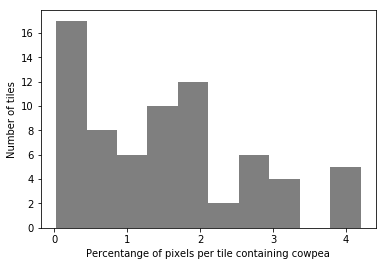

The following tiles are most populated by cowpea (ID, #pixels):
000981 172
001529 166
002583 165
000707 160
002302 157
002377 132
001865 132
001693 128
003252 122
000023 120


In [4]:
croptype = 12

import numpy
import matplotlib.pyplot
from grounddata import groundCropCountByTile

cropcount = groundCropCountByTile(datasetinfo)
filteredcropcount = cropcount[cropcount[:,croptype]>0][cropcount[cropcount[:,croptype]>0][:,croptype].argsort()][::-1]

print(f'Number of ground tiles containing {groundlabels[croptype]["crop"]}:',len(filteredcropcount))
print(f'Total number of pixels containing {groundlabels[croptype]["crop"]}:',numpy.sum(filteredcropcount[:,croptype]))
print(f'Distribution:')
fix,ax = matplotlib.pyplot.subplots()
ax.hist(filteredcropcount[:,croptype]/(numpy.sum(numpy.sum(filteredcropcount,axis=0)[0:len(groundlabels)]) / len(filteredcropcount))*100,color='black',alpha=0.5)
ax.set_xlabel(f'Percentange of pixels per tile containing {groundlabels[croptype]["crop"]}')
ax.set_ylabel('Number of tiles')
matplotlib.pyplot.show()
print(f'The following tiles are most populated by {groundlabels[croptype]["crop"]} (ID, #pixels):')
for i in range(0,10):
    print(str(filteredcropcount[i][len(groundlabels)]).rjust(6,'0'),filteredcropcount[i][croptype])

After selecting a particular labelled ground tile (e.g., "000707"), the following can then be used to view this tile.

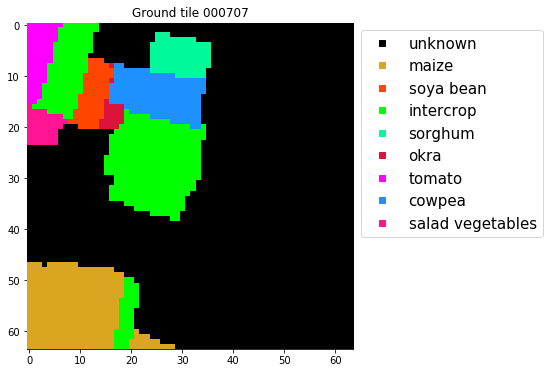

In [5]:
tileid = "000707"

from osgeo import gdal
from PIL import ImageColor

tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["groundcollection"]}/{datasetinfo["groundcollection"]}_{tileid}/labels.{datasetinfo["extension"]}')
tiledata = numpy.array(tile.GetRasterBand(1).ReadAsArray(),dtype='int')
uniquecrops = numpy.unique(tiledata)
uniqueknowncrops = numpy.unique(tiledata[tiledata != 0])

fig,ax = matplotlib.pyplot.subplots(figsize=[10,6])
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype='int')
for i in range(len(uniquecrops)):
    ax.plot(0,0,'s',color=groundlabels[uniquecrops[i]]['colour'],label=groundlabels[uniquecrops[i]]['crop'],zorder=0)
    colour = ImageColor.getcolor(groundlabels[uniquecrops[i]]['colour'],"RGB")
    rgb[tiledata == uniquecrops[i],0] = colour[0]
    rgb[tiledata == uniquecrops[i],1] = colour[1]
    rgb[tiledata == uniquecrops[i],2] = colour[2]
ax.imshow(rgb,interpolation=None,aspect='equal',zorder=10)
ax.set_title(f'Ground tile {tileid}')
ax.legend(bbox_to_anchor=(1.0,1.0),loc='upper left',fontsize=15)
matplotlib.pyplot.show()

The next step is to segment this labelled ground tile into the individual fields of crops. The variable "fieldmasks" provides masks for each field, which are accessible via the field IDs plotted below. At this stage it is also possible to erode the individual fields (via mathematical morphology), which might be useful in preventing edge effects from influencing the signal in the satellite imagery data.

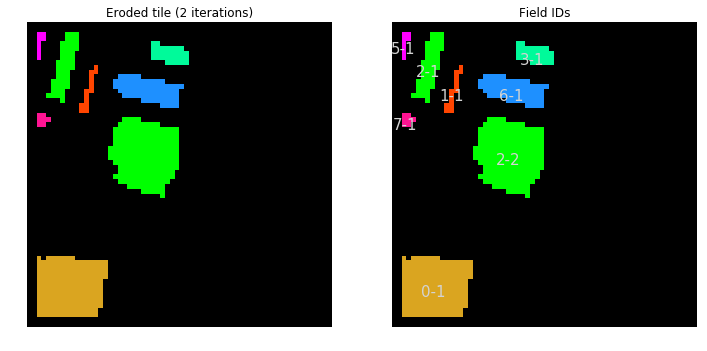

In [6]:
erosioniterations = 2
fieldmasks = [[]] * len(uniqueknowncrops)

import scipy.ndimage

connectionstructure = [[1,1,1],
                       [1,1,1],
                       [1,1,1]]
for i in range(len(uniqueknowncrops)):
    tmp = numpy.copy(tiledata)
    tmp[tmp != uniqueknowncrops[i]] = 0
    if erosioniterations > 0:
        erosionmask = scipy.ndimage.binary_erosion(tmp,iterations=erosioniterations)
        tmp[erosionmask == False] = 0
    fields = scipy.ndimage.label(tmp,structure=connectionstructure)
    fieldmasks[i] = fields
    
fig,ax = matplotlib.pyplot.subplots(1,2,figsize=[12,8])
axs = ax.ravel()
rgb = numpy.zeros([numpy.shape(tiledata)[0],numpy.shape(tiledata)[1],3],dtype='int')  
for i in range(len(fieldmasks)):
    colour = ImageColor.getcolor(groundlabels[uniqueknowncrops[i]]['colour'],"RGB")
    for j in range(1,fieldmasks[i][1]+1):
        com = scipy.ndimage.center_of_mass(fieldmasks[i][0] == j)
        axs[1].text(com[1]-3,com[0]+2,s=f'{i}-{j}',color='lightgrey',size=15,zorder=10)
        rgb[fieldmasks[i][0] == j,0] = colour[0]
        rgb[fieldmasks[i][0] == j,1] = colour[1]
        rgb[fieldmasks[i][0] == j,2] = colour[2]
axs[0].imshow(rgb,interpolation=None,aspect='equal',zorder=0)
axs[1].imshow(rgb,interpolation=None,aspect='equal',zorder=0)
axs[0].set_title(f'Eroded tile ({erosioniterations} iterations)')
axs[1].set_title(f'Field IDs')
axs[0].axis('off')
axs[1].axis('off')
matplotlib.pyplot.show()

### Part 2: The satellite imagery data

The second part of this notebook is used to visualise the satellite imagery data available over these fields. If the collections of satellite imagery were not downloaded by [mlhub_datadownload](mlhub_datadownload.ipynb), it is necessary to download the Sentinel-1 and Sentinel-2 items available for this particular labelled ground tile. The following checks whether these data already exist in the data directory, and if not, downloads them now.

In [7]:
import datetime
from mlhubdata import getItemFromCollection

s1items = getItemFromCollection(tileid,datasetinfo["s1collection"],datasetinfo)
s2items = getItemFromCollection(tileid,datasetinfo["s2collection"],datasetinfo)
s1items = sorted(s1items,key=lambda k:k["properties"]["datetime"])
s2items = sorted(s2items,key=lambda k:k["properties"]["datetime"])
s1dates = []
s2dates = []
for i in range(len(s1items)):
    s1dates.append(datetime.datetime.strptime(s1items[i]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())   
for i in range(len(s2items)):
    s2dates.append(datetime.datetime.strptime(s2items[i]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())

Items for su_african_crops_ghana_source_s1_000707 are available                                                          
Items for su_african_crops_ghana_source_s2_000707 are available                                                            


It is useful to first view a timeline of the availability of Sentinel-1 and Sentinel-2 observations over the labelled ground tile.

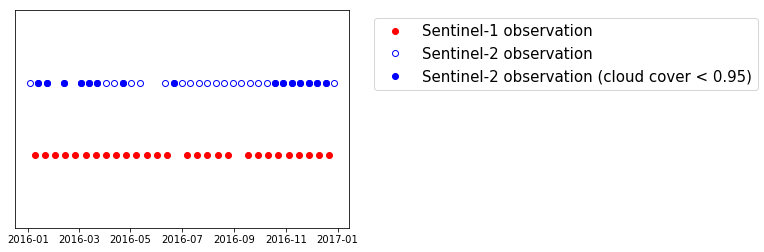

In [8]:
from satellitedata import cloudFreeS2Items

cloudcovermax = 0.95
s2cfitems = cloudFreeS2Items(s2items,cloudcovermax,datasetinfo)
s2cfdates = []
for i in range(len(s2cfitems)):
    s2cfdates.append(datetime.datetime.strptime(s2cfitems[i]["properties"]["datetime"],"%Y-%m-%dT%H:%M:%S+0000").date())
    
fig, ax = matplotlib.pyplot.subplots()
ax.plot(s1dates,numpy.zeros_like(s1dates),"o",color="red",label='Sentinel-1 observation')
ax.plot(s2dates,numpy.zeros_like(s2dates)+1,"o",color="blue",fillstyle='none',label=f'Sentinel-2 observation')
ax.plot(s2cfdates,numpy.zeros_like(s2cfdates)+1,"o",color="blue",label=f'Sentinel-2 observation (cloud cover < {cloudcovermax})')
ax.set_ylim([-1,2])
ax.set(yticklabels=[])
ax.tick_params(left=False)
ax.legend(bbox_to_anchor=(1.05,1.0),loc='upper left',fontsize=15)
matplotlib.pyplot.show()

It might also be useful to view a sequence of RGB composites from the clear(ish) Sentinel-2 observations across this timeline.

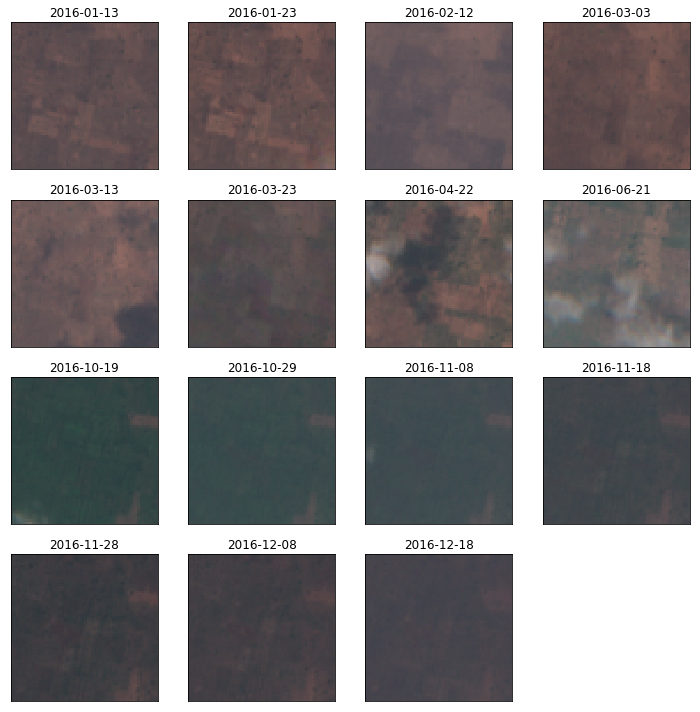

In [9]:
from satellitedata import rgbComposite

import math
ncols = 4
nrows = math.ceil(len(s2cfitems)/ncols)
fig, axs = matplotlib.pyplot.subplots(nrows,ncols,figsize=[10,10])
axs = axs.ravel()
for i in range(len(s2cfitems)):
    rgb = rgbComposite(s2cfitems[i],datasetinfo)
    axs[i].imshow(rgb,interpolation=None,aspect='equal')
    axs[i].set_title(s2cfdates[i])
    axs[i].set(xticklabels=[])
    axs[i].set(yticklabels=[])
    axs[i].tick_params(bottom=False)
    axs[i].tick_params(left=False)
for i in range(0,ncols*nrows):
    if i >= len(s2cfitems):
        fig.delaxes(axs[i])
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

Next, the following visualises the Sentinel-1 VHVV ratio, as a function of time, for selected fields via the "fieldselection" variable. In this example, the fields 0-1, 3-1 and 6-1 have been selected (maize, sorghum and cowpea, respectively).

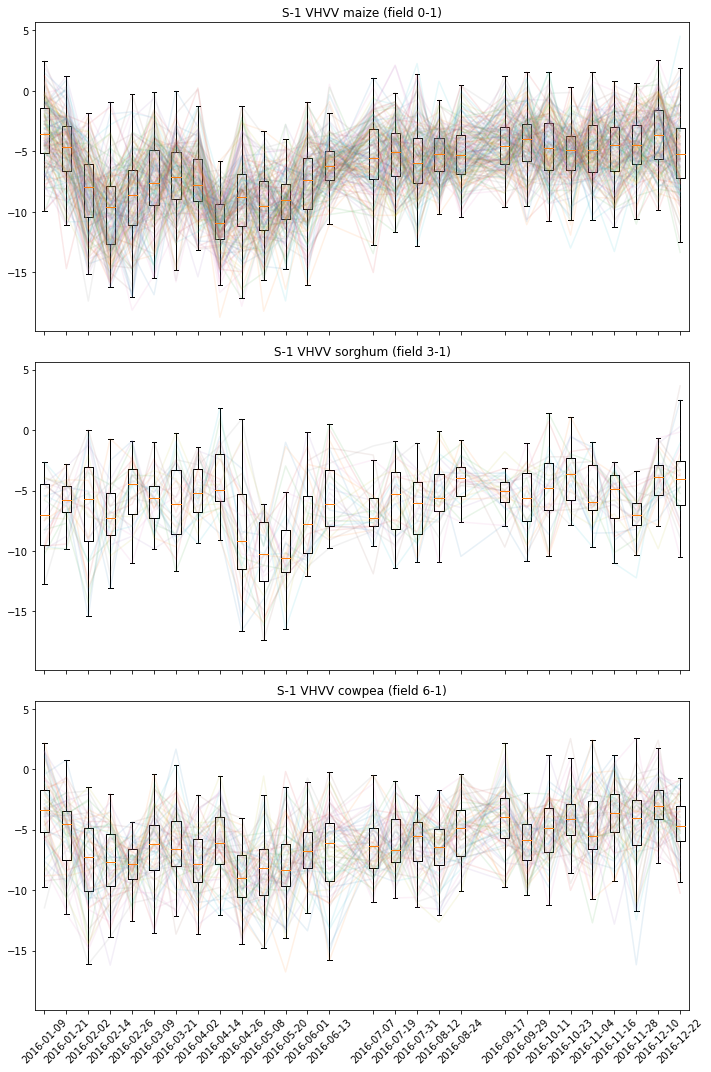

In [10]:
fieldselection = [[0,1],[3,1],[6,1]]

from plotting import datepositions

s1data = numpy.zeros([len(s1items),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
for i in range(len(s1items)):
    s1tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s1collection"]}/{s1items[i]["id"]}/source.{datasetinfo["extension"]}')
    s1data[i] = (s1tile.GetRasterBand(2).ReadAsArray() - s1tile.GetRasterBand(1).ReadAsArray())

fig,ax = matplotlib.pyplot.subplots(len(fieldselection),1,figsize=[10,15],sharex='col',sharey='col')
axs = ax.ravel()
for i in range(len(fieldselection)):
    data = []
    for j in range(len(s1items)):
        data.append(s1data[j][fieldmasks[fieldselection[i][0]][0] == fieldselection[i][1]])
    axs[i].boxplot(data,positions=datepositions(s1dates),widths=5,showfliers=False)
    axs[i].plot(datepositions(s1dates),data,alpha=0.1)
    axs[i].set_xlim([-5,max(datepositions(s1dates))+5])
    axs[i].set_xticklabels(s1dates,rotation=45)
    axs[i].set_title(f'S-1 VHVV {groundlabels[uniqueknowncrops[fieldselection[i][0]]]["crop"]} (field {fieldselection[i][0]}-{fieldselection[i][1]})')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

The following then visualises several indices generated from the Sentinel-2 observations, for the selected fields, as a function of time. In this example, the indices are: normalised difference vegetation index, green chlorophyll index, red-edge chlorophyll index and normalised difference water index.

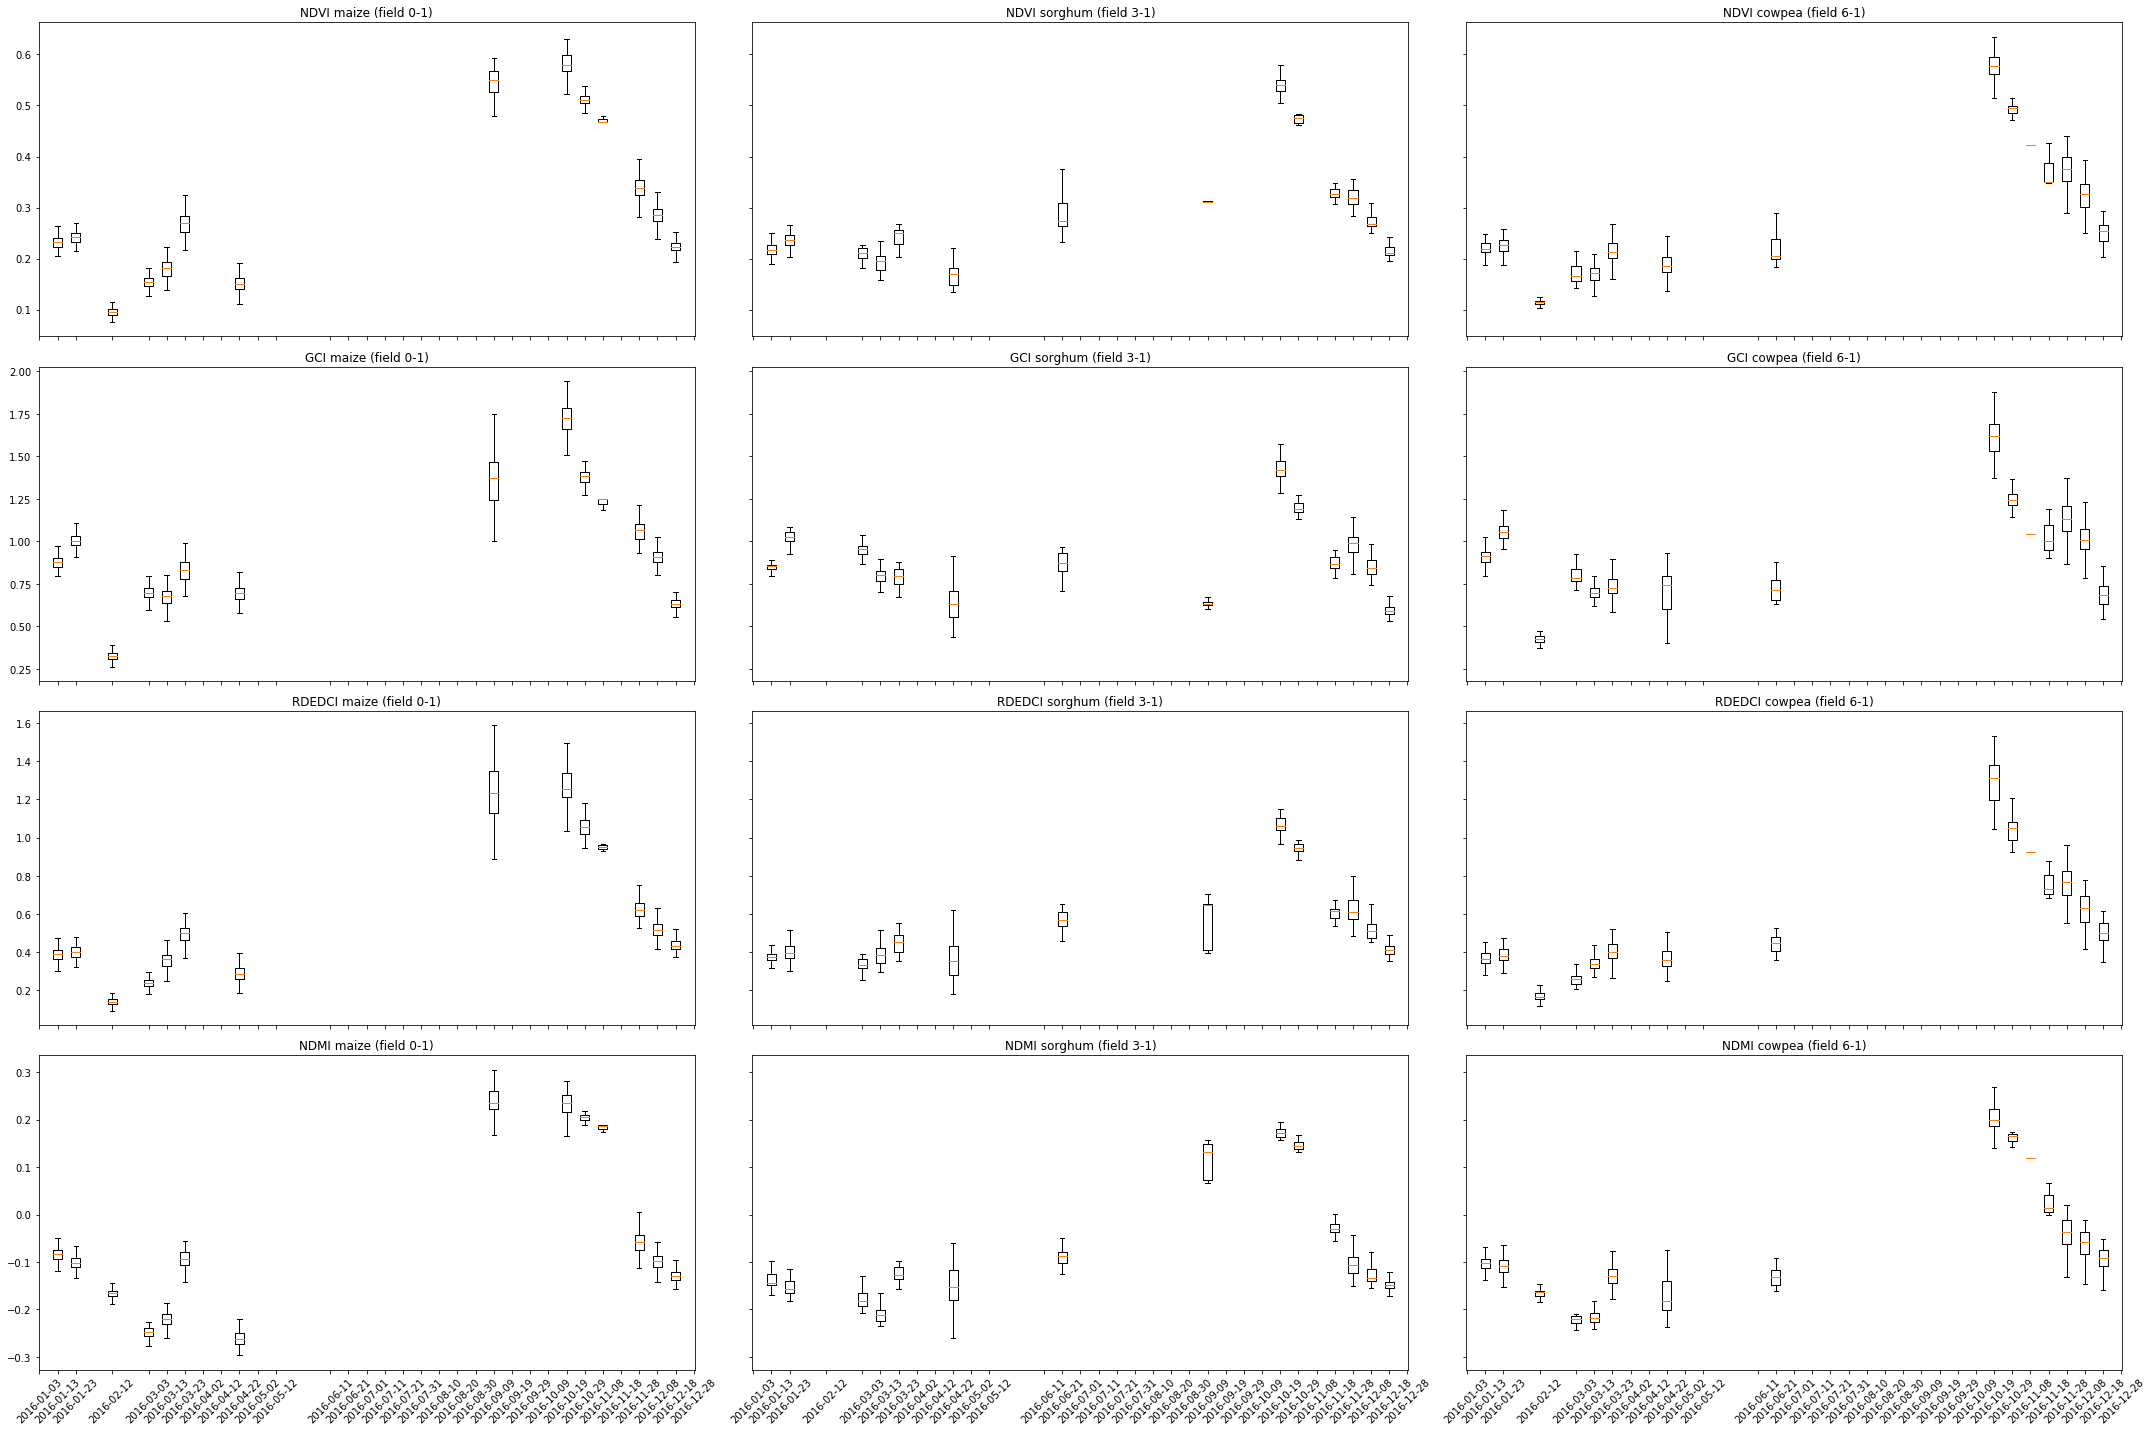

In [11]:
spectra = ["BLUE","GREEN","RED","RDED1","RDED2","RDED3","NIR","RDED4","SWIR1","SWIR2"]
wavelengths = [490,560,665,705,740,783,842,865,1610,2190]
vis = ["NDVI","GCI","RDEDCI","NDMI"]

s2spectra = numpy.zeros([len(s2items),len(spectra),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
s2vis = numpy.zeros([len(s2items),len(vis),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]])
s2cloudmasks = numpy.zeros([len(s2items),numpy.shape(tiledata)[0],numpy.shape(tiledata)[1]],dtype='int')

for i in range(len(s2items)):
    s2tile = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s2collection"]}/{s2items[i]["id"]}/source.{datasetinfo["extension"]}')
    s2mask = gdal.Open(f'{datasetinfo["datadir"]}{datasetinfo["s2collection"]}/{s2items[i]["id"]}/cloudmask.{datasetinfo["extension"]}')
    for j in range(len(spectra)):
        s2spectra[i][j] = s2tile.GetRasterBand(j+1).ReadAsArray() / 4096.
    s2cloudmasks[i] = s2mask.GetRasterBand(1).ReadAsArray() 
    s2vis[i][0] = (s2spectra[i][6] - s2spectra[i][2]) / (s2spectra[i][6] + s2spectra[i][2])
    s2vis[i][1] = (s2spectra[i][6] / s2spectra[i][1]) - 1 
    s2vis[i][2] = (s2spectra[i][6] / s2spectra[i][3]) - 1 
    s2vis[i][3] = (s2spectra[i][6] - s2spectra[i][8]) / (s2spectra[i][6] + s2spectra[i][8])

fig,ax = matplotlib.pyplot.subplots(len(vis),len(fieldselection),figsize=[30,20],sharex='col',sharey='row')
axs = ax.ravel()
idx = 0
for i in range(len(vis)):
    for j in range(len(fieldselection)):
        data = []
        for k in range(len(s2items)):
            fieldcloudmask = numpy.copy(fieldmasks[fieldselection[j][0]][0])
            fieldcloudmask[s2cloudmasks[k] != 0] = 0
            data.append(s2vis[k][i][fieldcloudmask == fieldselection[j][1]])
        axs[idx].boxplot(data,positions=datepositions(s2dates),widths=5,showfliers=False)
        axs[idx].set_xticklabels(s2dates,rotation=45)
        axs[idx].set_title(f'{vis[i]} {groundlabels[uniqueknowncrops[fieldselection[j][0]]]["crop"]} (field {fieldselection[j][0]}-{fieldselection[j][1]})')
        idx = idx + 1
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()    

Finally, the Sentinel-2 spectra can be plotted for the selected fields, as a function of wavelength, using only the clear observations shown in the sequence of RGB composites.

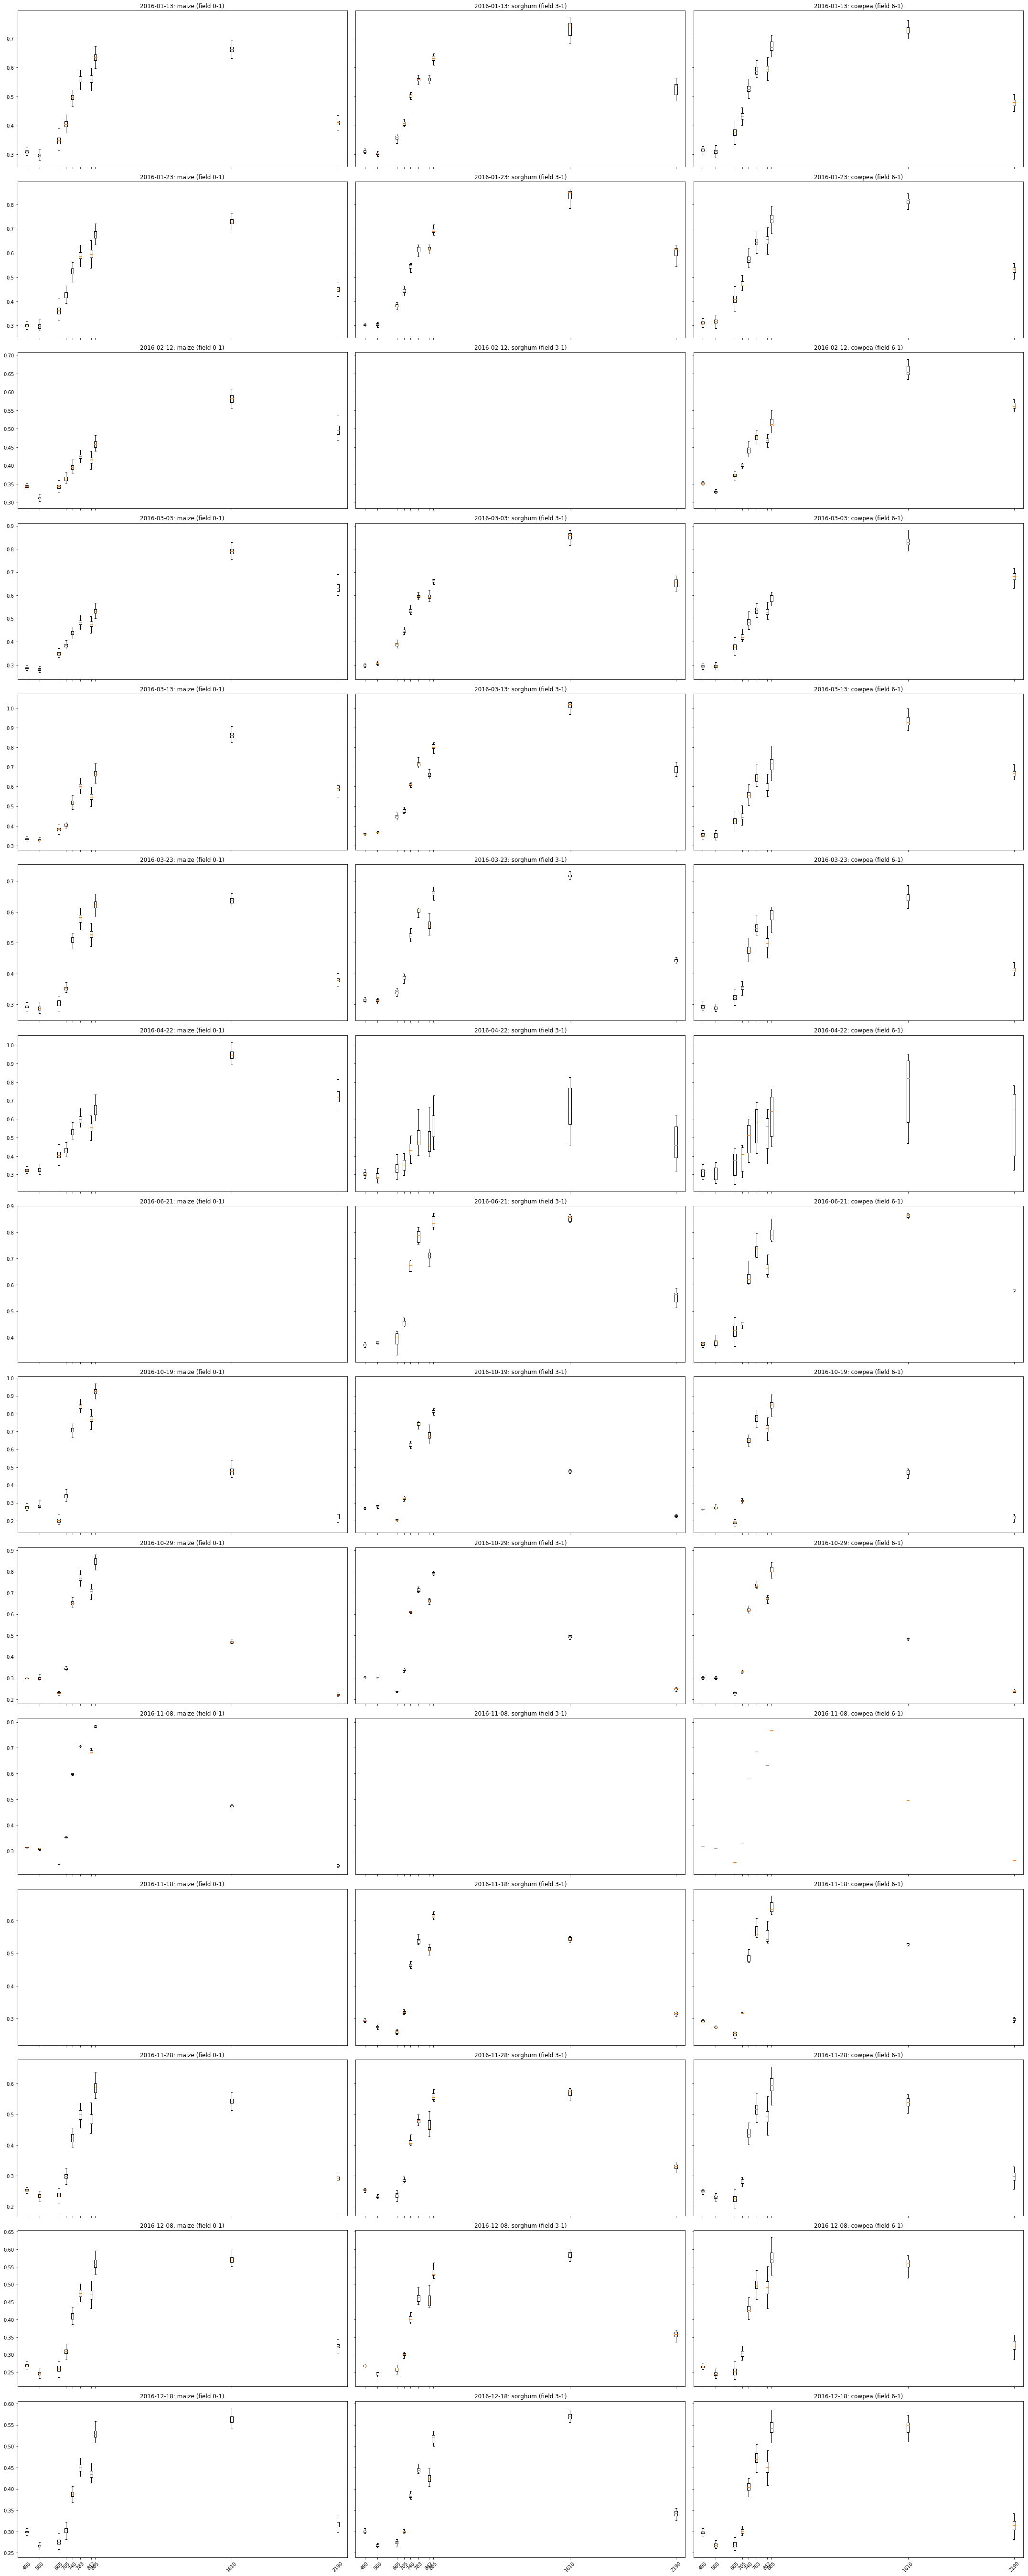

In [12]:
fig,ax = matplotlib.pyplot.subplots(len(s2cfdates),len(fieldselection),figsize=[30,75],sharex='col',sharey='row')
axs = ax.ravel()
idx = 0
datecount = 0
for i in range(len(s2items)):
    if (s2dates[i] in s2cfdates) == True:
        for k in range(len(fieldselection)):
            data = []
            fieldcloudmask = numpy.copy(fieldmasks[fieldselection[k][0]][0])
            fieldcloudmask[s2cloudmasks[i] != 0] = 0
            for j in range(len(spectra)):
                data.append(s2spectra[i][j][fieldcloudmask == fieldselection[k][1]])
            axs[idx].boxplot(data,positions=wavelengths,widths=15,showfliers=False)
            axs[idx].set_xlim([min(wavelengths)-50,max(wavelengths)+50])
            axs[idx].set_xticklabels(wavelengths,rotation=45)
            axs[idx].set_title(f'{s2cfdates[datecount]}: {groundlabels[uniqueknowncrops[fieldselection[k][0]]]["crop"]} (field {fieldselection[k][0]}-{fieldselection[k][1]})')
            idx = idx + 1
        datecount = datecount+1
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()